In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from lmfit import Model
from scipy.stats import linregress
from scipy import integrate

In [2]:
# Variables

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()
pitt_df = pd.DataFrame()

final_results = {}

F = 96485 # C/mol
# col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']

potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]

formatter_1e3 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter_1e6 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1e4 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))



In [3]:
# Methods
color = 'tab:orange'
def capacity_cv(df, dpi, area, thickness, time_cut_off_beg, time_cut_off_end, pot_axis):
    x = df[col_cv[3]][time_cut_off_beg:time_cut_off_end]
    y = df[col_cv[1]][time_cut_off_beg:time_cut_off_end]# / area # Current Density
    x2 = df[col_cv[0]][time_cut_off_beg:time_cut_off_end] # Potential
    area_under_curve = np.trapz(y, x)
    capacity = area_under_curve /3.6 / (1e-7 * thickness * area) # removed area since we have current density
    if capacity < 0:
        capacity = -capacity
    text  = f'{round(capacity)} mAh/cm$^3$'
    
    fig, ax = plt.subplots(dpi = dpi, figsize = (8, 5))
    sns.lineplot(x = x, y = y, color = color)
    ax.axhline(y = 0, color = 'gray', linestyle = '--')
    plt.fill_between(x, y, alpha=0.1, color = color)#, color = 'tab:blue')
    plt.text(x.median(), y.mean(), text)
    ax.yaxis.set_major_formatter(formatter_1e6)
    plt.ylabel('Current (µA)')
    if pot_axis == True:
        ax2 = ax.twiny()
        ax2.grid()
        sns.lineplot(x = x2, y = y, ax = ax2, color = color) #, color = 'tab:green')
        if y.mean() < 0:
            plt.gca().invert_xaxis()
    
def charge_cv(df, dpi, time_cut_off_beg, time_cut_off_end, pot_axis):
    x = df[col_cv[3]][time_cut_off_beg:time_cut_off_end]
    y = df[col_cv[1]][time_cut_off_beg:time_cut_off_end]# / area # Current Density
    x2 = df[col_cv[0]][time_cut_off_beg:time_cut_off_end] # Potential
    area_under_curve = np.trapz(y, x)
    if area_under_curve < 0:
        charge = -area_under_curve
    else:
        charge = area_under_curve
        
    text  = f'{round(charge * 1e3, 3)} mC' # mAh/cm$^3$
    
    fig, ax = plt.subplots(dpi = dpi, figsize = (8, 5))
    sns.lineplot(x = x, y = y, color = color )
    ax.axhline(y = 0, color = 'gray', linestyle = '--')
    plt.fill_between(x, y, alpha=0.1, color = color)#, color = 'tab:orange')
    plt.text(x.median(), y.mean(), text)
    ax.yaxis.set_major_formatter(formatter_1e6)
    plt.ylabel('Current (µA)')
    
    if pot_axis == True:
        ax2 = ax.twiny()
        ax2.grid()
        sns.lineplot(x = x2, y = y, ax = ax2, color = color)
        if y.mean() < 0:
            plt.gca().invert_xaxis()

        

In [52]:
# Old LMO

area = np.pi
thickness = 90

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\SCE_mimic\Full lithiation'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
df1 = pd.read_csv(file, sep = ';')
df1['Corrected Time'] = df1['Time (s)'] - df1['Time (s)'][0]
df1 = df1.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0]})

df1['Current Density (µA/cm$^2$)'] = df1[col_cv[1]] / area

dpi = 100

# fig, ax = plt.subplots(dpi = dpi)
# sns.scatterplot(x = df1[col_cv[0]], y = df1['Current Density (µA/cm$^2$)'], edgecolor = None, s = 3) #, color = 'tab:green')
# ax.yaxis.set_major_formatter(formatter_1e6)
# ax.grid()

# capacity_cv(df1, dpi, area, thickness, 3250, 4660, True)
# charge_cv(df1, dpi,  3250, 4660, True)
# capacity_cv(df1, dpi, area, thickness, 4730, 6520, True)
# charge_cv(df1, dpi, 4730, 6520, True)

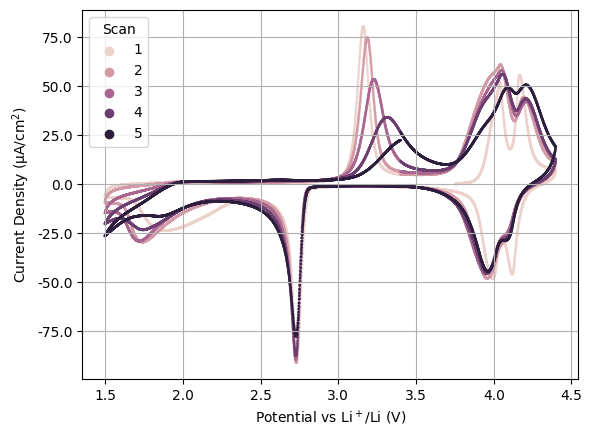

In [53]:
### New LMO

area = np.pi
thickness = 90

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD_CV'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
df_n = pd.read_csv(file, sep = ';')
df_n['Corrected Time'] = df_n['Time (s)'] - df_n['Time (s)'][0]
df_n = df_n.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time(s)',
                          'WE(1).Potential (V)' : col_cv[0]})

df_n['Current Density (µA/cm$^2$)'] = df_n[col_cv[1]] / area


fig, ax = plt.subplots(dpi = dpi)
sns.scatterplot(data = df_n, x = col_cv[0], y = 'Current Density (µA/cm$^2$)', hue = 'Scan', edgecolor = None, s = 3) #, color = 'tab:green')
ax.yaxis.set_major_formatter(formatter_1e6)
ax.grid()


In [43]:
# TiO2 capacity from CV
#Total capacity Li2Mn2O4 1260 mAh/cm3

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\ALD TiO2\144cycles_ext\1C\CV'
cv_path = [os.path.join(path, i) for i in os.listdir(path)]
area = np.pi
thickness = 90

df = pd.read_csv(cv_path[0], sep = ';')
df['Corrected Time'] = df['Time (s)'] - df['Time (s)'][0]
df = df.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0]})
df['Current Density (µA/cm$^2$)'] = df[col_cv[1]] / area

dpi = 200
# fig, ax = plt.subplots(dpi = dpi)
# sns.scatterplot(x = df[col_cv[0]], y = df['Current Density (µA/cm$^2$)'], edgecolor = None, s = 3, color = 'tab:orange')
# ax.yaxis.set_major_formatter(formatter_1e6)

# charge_cv(df, dpi, 10, 1600, True)
# charge_cv(df, dpi, 10, 2070, False)

# charge_cv(df, dpi, 2070, 3750, True)
# charge_cv(df, dpi, 2070, 4780, True)
# charge_cv(df, dpi, 5020, 6100, False)
# charge_cv(df, dpi, 6200, 7780, True)
# charge_cv(df, dpi, 5100, 7780, True)

# capacity_cv(df, dpi, area, 9, 5020, 6000, False)
# plt.xlim(1.55, 2.75)
